# Visualizing Quality Attribute Coupling

## Getting started

Run the Quartermaster simulation to produce the time series data in `out\models\` and aggregate data in `out\models\scenario`

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

ALoad = pd.read_csv("../out/models/A-100-Naive-VaryLoad.csv")
BLoad = pd.read_csv("../out/models/B-100-LoadLeveling-VaryLoad.csv")
CLoad = pd.read_csv("../out/models/C-100-LoadShedding-VaryLoad.csv")
DLoad = pd.read_csv("../out/models/D-100-MultilevelLoadShedding-VaryLoad.csv")
LoadSlice = (51,76)
Load = { "name":"Load", "series":{ "A":ALoad, "B":BLoad, "C":CLoad, "D":DLoad }, "slice":LoadSlice }


ALatency = pd.read_csv("../out/models/A-100-Naive-VaryLatency.csv")
ELatency = pd.read_csv("../out/models/E-100-RequestCaching-VaryLatency.csv")
FLatency = pd.read_csv("../out/models/F-100-AsyncCacheLoading-VaryLatency.csv")
GLatency = pd.read_csv("../out/models/G-100-PerRequestTimeout-VaryLatency.csv")
LatencySlice = (81,161)
Latency = { "name":"Latency", "series":{ "A":ALatency, "E":ELatency, "F":FLatency, "G":GLatency }, "slice":LatencySlice }

AAvailability = pd.read_csv("../out/models/A-100-Naive-VaryAvailability.csv")
HAvailability = pd.read_csv("../out/models/H-100-Retries-VaryAvailability.csv")
FAvailability = pd.read_csv("../out/models/F-100-AsyncCacheLoading-VaryAvailability.csv")
IAvailability = pd.read_csv("../out/models/I-100-AsyncRetries-VaryAvailability.csv")
JAvailability = pd.read_csv("../out/models/J-100-InfiniteRetries-VaryAvailability.csv")
AvailabilitySlice = (82,164)
Availability = { "name":"Availability", "series":{ "A":AAvailability, "H":HAvailability, "F":FAvailability, "I":IAvailability, "J":JAvailability }, "slice":AvailabilitySlice }

ACapacity = pd.read_csv("../out/models/A-100-Naive-VaryCapacity.csv")
KCapacity = pd.read_csv("../out/models/K-100-CooperativePoolSizing-VaryCapacity.csv")
LCapacity = pd.read_csv("../out/models/L-100-InferredPoolSizing-VaryCapacity.csv")
CapacitySlice = (50,76)
Capacity = { "name":"Capacity", "series":{ "A":ACapacity, "K":KCapacity, "L":LCapacity }, "slice":CapacitySlice }


## Time Series Lagged Cross-Correlation

You are currently viewing what we call our Notebook Editor. It is an interactive document based on Jupyter Notebooks that supports the intermixing of code, outputs and markdown documentation. 

This cell is a markdown cell. To edit the text in this cell, simply double click on the cell to change it into edit mode.

The next cell below is a code cell. You can switch a cell between code and markdown by clicking on the code ![code icon](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/codeIcon.PNG) /markdown ![markdown icon](https://raw.githubusercontent.com/microsoft/vscode-python/main/images/markdownIcon.PNG) icons or using the keyboard shortcut `M` and `Y` respectively.

In [2]:
""" Some assistance from this article
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
"""

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


def normcrosscorr(datax, datay, lag=0, wrap=False):
    # Mean Normalization
    normalizedx = (datax - datax.mean()) / (datax.std())
    normalizedy = (datay - datay.mean()) / (datay.std())

    # Min-Max Normalization
    #normalizedx = (datax - datax.min()) / (datax.max()-datax.min())
    #normalizedy = (datay - datay.min()) / (datay.max()-datay.min())
    return crosscorr(normalizedx, normalizedy, lag, wrap)


def timeseriescorr(d1, d2, window, normalize=False):
    if normalize:
        rs = [normcrosscorr(d1, d2, lag) for lag in range(-window, 1)]
    else:
        rs = [crosscorr(d1, d2, lag) for lag in range(-window, 1)]

    # Early exit if no window
    if window == 0:
        #print(window, 0, rs)
        return rs[0], 0
    
    maxCrossCorr = np.amax(rs)
    maxCrossCorrIndex = np.argmax(rs)
    minCrossCorr = np.amin(rs)
    minCrossCorrIndex = np.argmin(rs)

    actualCrossCorr = 0
    actualCrossCorrIndex = 0

    if maxCrossCorr > -1 * minCrossCorr:
        actualCrossCorr = maxCrossCorr
        actualCrossCorrIndex = maxCrossCorrIndex
    else:
        actualCrossCorr = minCrossCorr
        actualCrossCorrIndex = minCrossCorrIndex

    offset = -window + actualCrossCorrIndex
    #print(window, actualCrossCorrIndex, rs)

    return actualCrossCorr, offset
    


def scenario_metric(scenario, independent, dependent):
    print(scenario["name"])
    print("\t", independent, "->", dependent)
    for key, timeseries in scenario["series"].items():
        slice = scenario["slice"]

        d1 = timeseries[independent][slice[0]:slice[1]]
        d2 = timeseries[dependent][slice[0]:slice[1]]
        print(f"\t\t{key}", timeseriescorr(d1, d2, 0), timeseriescorr(d1, d2, 0, normalize=True))


scenario_metric(Load, "loadFromX", "loadFromY")
scenario_metric(Load, "loadFromX", "meanLatencyFromY")

scenario_metric(Latency, "meanLatencyFromZ", "meanLatencyFromY")
scenario_metric(Latency, "meanLatencyFromZ", "meanAvailabilityFromY")

scenario_metric(Availability, "meanAvailabilityFromZ", "meanAvailabilityFromY")
scenario_metric(Availability, "meanAvailabilityFromZ", "loadFromY")

scenario_metric(Capacity, "zCapacity", "poolSize")


Load
	 loadFromX -> loadFromY
		A (0.9999987201860776, 0) (0.9999987201860777, 0)
		B (0.6822942824451848, 0) (0.682294282445185, 0)
		C (0.9257416248654748, 0) (0.9257416248654751, 0)
		D (0.924497963742875, 0) (0.9244979637428753, 0)
Load
	 loadFromX -> meanLatencyFromY
		A (-0.8843401490395091, 0) (-0.8843401490395089, 0)
		B (0.14335400504759344, 0) (0.1433540050475934, 0)
		C (0.764618307841908, 0) (0.7646183078419081, 0)
		D (0.586042508632059, 0) (0.5860425086320591, 0)
Latency
	 meanLatencyFromZ -> meanLatencyFromY
		A (0.9285114648280477, 0) (0.9285114648280478, 0)
		E (0.8556450211770733, 0) (0.8556450211770734, 0)
		F (nan, 0) (nan, 0)
		G (-0.217823189177849, 0) (-0.2178231891778488, 0)
Latency
	 meanLatencyFromZ -> meanAvailabilityFromY
		A (-0.9528673792735823, 0) (-0.9528673792735826, 0)
		E (-0.9155175442823599, 0) (-0.9155175442823597, 0)
		F (0.09595300997415167, 0) (0.09595300997415163, 0)
		G (-0.9514575765339959, 0) (-0.9514575765339958, 0)
Availability
	 meanAvail

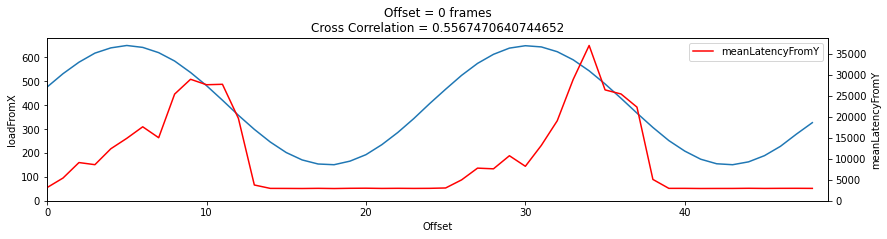

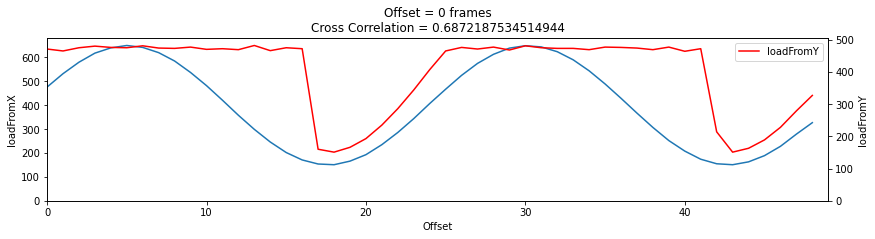

In [3]:
import matplotlib.pyplot as plot

def drawcrosscorrelation(model, slice, independent, dependent, normalize=False):
    d1 = model[independent][slice[0]:]#:slice[1]]
    d2 = model[dependent][slice[0]:]#:slice[1]]

    maxCrossCorr, offset = timeseriescorr(d1, d2, 0, normalize=normalize)
    
    f,ax=plot.subplots(figsize=(14,3))
    
    ax.plot(d1.values)
    ax.set(title=f'Offset = {offset} frames\nCross Correlation = {maxCrossCorr}',ylim=[0,np.amax(d1)*1.05],xlim=[0,d1.size], xlabel='Offset',ylabel=independent)

    ax2 = ax.twinx()
    ax2.plot(d2.shift(int(offset)).values, color="red", label=dependent)
    ax2.set(ylim=[0,np.amax(d2)*1.05],xlim=[0,d2.size],ylabel=dependent)

    plot.legend()

drawcrosscorrelation(DLoad, LoadSlice, "loadFromX", "meanLatencyFromY")
#drawnormcrosscorrelation(DLoad, "loadFromX", "meanLatencyFromY")
#drawnormcrosscorrelation(BLoad, "loadFromX", "loadFromY")
drawcrosscorrelation(BLoad, LoadSlice, "loadFromX", "loadFromY")
#drawcrosscorrelation(ELatency, "meanLatencyFromZ", "meanAvailabilityFromY")

### Why Scenarios are important

In [4]:
drawcrosscorrelation(AAvailability, AvailabilitySlice, "meanLatencyFromZ", "meanLatencyFromY")
drawcrosscorrelation(ALatency, LatencySlice, "meanLatencyFromZ", "meanLatencyFromY")

TypeError: drawcrosscorrelation() missing 1 required positional argument: 'dependent'

## Unfortunate Problems

### E Latency > A Latency
- A is 0 delay, cross correlation = 0.921664
- E is 6 delay, cross correlation = 0.944452

Is this bad or good?

## Dynamic Time Warping


Load
	loadOnZ
		A 4.0
		B 6103.0
		C 5018.0
		D 5032.0
	meanLatencyFromY
		A 231481.44629586147
		B 4783684.134355391
		C 951527.9948407738
		D 962688.9272827767
Latency
	meanLatencyFromY
		A 224294.34385899288
		E 332779.6517628308
		F 1260446.9241867515
		G 374669.1462791247
	meanAvailabilityFromZ
		A 1267483.47681865
		E 1267284.9430928412
		F 1261138.2491867503
		G 1266342.8694670019
Availability
	meanAvailabilityFromZ
		A 0.0
		H 7.0126513927970855
		F 34.35069342978139
		I 47.417897938978506
		J 37.89335828373264
	loadOnZ
		A 39887.45882688432
		H 69693.10607119091
		F 39687.32403167776
		I 96480.83368564847
		J 68284.54415902654
Capacity
	workerThreadPoolSizeInY
		A inf
		K 2.0
		L 296.0


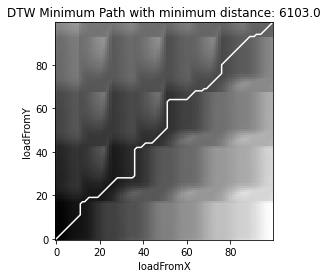

In [102]:
from dtw import dtw,accelerated_dtw

def dynamictimewarpingcorrelation(df, d1name, d2name):
    d1 = df[d1name].values
    d2 = df[d2name].values
    d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')
    return d


print("Load")
print("\tloadOnZ")
for key, series in Load.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "loadFromX", "loadFromY"))
print("\tmeanLatencyFromY")
for key, series in Load.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "loadFromX", "meanLatencyFromY"))
    #print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanLatencyFromY", "meanLatencyFromZ"))

print("Latency")
print("\tmeanLatencyFromY")
for key, series in Latency.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanLatencyFromZ", "meanLatencyFromY"))
print("\tmeanAvailabilityFromZ")
for key, series in Latency.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanLatencyFromZ", "meanAvailabilityFromY"))
    #print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanAvailabilityFromY", "meanAvailabilityFromZ"))

print("Availability")
print("\tmeanAvailabilityFromZ")
for key, series in Availability.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanAvailabilityFromZ", "meanAvailabilityFromY"))
    #print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanAvailabilityFromY", "meanAvailabilityFromZ"))
print("\tloadOnZ")
for key, series in Availability.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "meanAvailabilityFromZ", "loadFromY"))
    #print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "loadFromX", "loadFromY"))

print("Capacity")
print("\tworkerThreadPoolSizeInY")
for key, series in Capacity.items():
    print(f"\t\t{key}", dynamictimewarpingcorrelation(series, "zCapacity", "poolSize"))




df = BLoad
#driven
d1 = df["loadFromX"].values
d2 = df["loadFromY"].values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plot.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plot.plot(path[0], path[1], 'w')
plot.xlabel('loadFromX')
plot.ylabel('loadFromY')
plot.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plot.show()